In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Load data analysis and visualization libraries
# NumPy is used for numerical computations
# Pandas is used for data manipulation and analysis
# Matplotlib is used for creating plots and visualizations
# Seaborn is used for creating more aesthetically pleasing visualizations
# Glob is used for searching files using patterns

In [ ]:
# Use the glob library to search for CSV files in the './EyeT/' directory
data_files = glob.glob('./EyeT/*.csv')
# 'data_files' will store a list of file paths matching the specified pattern

In [ ]:
# List of columns to be dropped from the dataset
drop_columns = ['Mouse position X', 'Mouse position Y', 'Fixation point X (MCSnorm)', 'Fixation point Y (MCSnorm)',
                'Event', 'Event value',
                'Computer timestamp', 'Export date', 'Recording date',
                'Recording date UTC', 'Recording start time', 'Timeline name', 'Recording Fixation filter name',
                'Recording software version', 'Recording resolution height', 'Recording resolution width',
                'Recording monitor latency', 'Presented Media width', 'Presented Media height',
                'Presented Media position X (DACSpx)', 'Presented Media position Y (DACSpx)', 'Original Media width',
                'Recording start time UTC', 'Original Media height', 'Sensor']
# Columns listed here will be dropped from the dataset using DataFrame.drop()


str_columns = ['Gaze direction left X', 'Gaze direction left Y', 'Gaze direction left Z',
                'Gaze direction right X', 'Gaze direction right Y', 'Gaze direction right Z',
                'Eye position left X (DACSmm)', 'Eye position left Y (DACSmm)', 'Eye position left Z (DACSmm)',
                'Eye position right X (DACSmm)', 'Eye position right Y (DACSmm)', 'Eye position right Z (DACSmm)',
                'Gaze point left X (DACSmm)', 'Gaze point left Y (DACSmm)', 'Gaze point right X (DACSmm)',
                'Gaze point right Y (DACSmm)', 'Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)',
                'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)',
                'Gaze point right Y (MCSnorm)', 'Pupil diameter left', 'Pupil diameter right']
# Columns listed here are expected to contain string values (potentially non-numeric)
# These columns might need to be converted to appropriate data types for analysis

In [ ]:
def process_data(df):
    # List of columns with missing or NaN values that need to be filled
    fill_columns = ['Pupil diameter right', 'Pupil diameter left', 'Fixation point X', 'Fixation point Y']

    # Forward fill missing values in the specified columns
    df[fill_columns] = df[fill_columns].ffill()

    # Convert string columns to numeric, replacing commas with periods and handling errors
    for i in range(len(str_columns)):
        df[str_columns[i]] = pd.to_numeric(df[str_columns[i]].str.replace(',', '.'), errors='coerce')

    return df
# The function 'process_data' takes a DataFrame 'df' as input, performs data processing steps on it,
# and then returns the processed DataFrame.
# Missing values in 'fill_columns' are forward-filled to avoid gaps in the data.

In [ ]:
def add_data_specifications(data, id):
    # Filter out rows with valid eye movement data
    valid_data = data[(data['Validity left'] == 'Valid') & (data['Validity right'] == 'Valid')]

    # Filter fixation data and calculate related statistics
    fixation_data = data[data['Eye movement type'] == 'Fixation']
    num_fixation = len(fixation_data)
    mean_fix_duration = fixation_data['Gaze event duration'].mean()

    # Calculate statistics for pupil diameter, gaze point, and fixation point columns
    pupil_diameter_stats = data[['Pupil diameter left', 'Pupil diameter right']].mean(axis=1).agg(['mean', 'median', 'std']).rename(lambda x: f'Pupil Diameter {x.capitalize()}')
    gaze_point_x_stats = data['Gaze point X'].agg(['mean', 'median', 'std']).rename(lambda x: f'Gaze Point X {x.capitalize()}')
    gaze_point_y_stats = data['Gaze point Y'].agg(['mean', 'median', 'std']).rename(lambda x: f'Gaze Point Y {x.capitalize()}')
    fixation_point_x_stats = data['Fixation point X'].agg(['mean', 'median', 'std']).rename(lambda x: f'Fixation Point X {x.capitalize()}')
    fixation_point_y_stats = data['Fixation point Y'].agg(['mean', 'median', 'std']).rename(lambda x: f'Fixation Point Y {x.capitalize()}')

    # Create a dictionary containing summary data
    summary_data = {
        'Participant Name': data['Participant name'].iloc[0],
        'Project Name': id,
        'Recording Name': data['Recording name'].iloc[0],
        'Total Fixations': num_fixation,
        'Avg. Fixation Duration': mean_fix_duration
    }
    # Update the dictionary with calculated statistics
    summary_data.update(pupil_diameter_stats)
    summary_data.update(gaze_point_x_stats)
    summary_data.update(gaze_point_y_stats)
    summary_data.update(fixation_point_x_stats)
    summary_data.update(fixation_point_y_stats)

    # Create a DataFrame using the summary data dictionary
    summary = pd.DataFrame(summary_data, index=[0])

    return summary


In [ ]:
def empathy_score(data):
    # Calculate the mean of original and predicted empathy scores for each participant
    mean_val = data.groupby('Participant Name').agg({'Original Empathy Score': 'first', 'Predicted Empathy Score': 'mean'})

    # Reshape the DataFrame for visualization
    alt_df = mean_val.reset_index().melt(id_vars=['Participant Name'], value_vars=['Original Empathy Score', 'Predicted Empathy Score'], var_name='Score Type', value_name='Score')

    # Select a sample of participants for visualization
    sample_participants = alt_df['Participant Name'].unique()[:5]
    filter_alt_df = alt_df[alt_df['Participant Name'].isin(sample_participants)]

    # Create a bar plot using Seaborn
    plt.figure(figsize=(10, 5))
    sns.barplot(data=filter_alt_df, x='Participant Name', y='Score', hue='Score Type')

    # Add title and labels to the plot
    plt.title('Bar Plot of Actual and Predicted Empathy Scores for the First few Participants')
    plt.xlabel('Participant Name')
    plt.ylabel('Empathy Score')

    # Display the plot
    plt.show()


In [ ]:
import os

# Initialize an empty list to store summary DataFrames
df_list = []

# Iterate through the list of data files
for f in data_files:
    # Read the CSV file into a DataFrame, excluding columns with index 0, and handling low memory
    data = pd.read_csv(f, usecols=lambda column: column != 0, low_memory=True)

    # Process the data using the defined 'process_data' function
    processed_data = process_data(data)

    fname = os.path.basename(f)

    # Determine the group based on the file name prefix
    if fname.startswith('EyeT_group_dataset_III_'):
        group = 'Test group experiment'
    elif fname.startswith('EyeT_group_dataset_II_'):
        group = 'Control group experiment'

    # Generate a summary DataFrame using the 'add_data_specs' function
    summary = add_data_specifications(processed_data, group)

    # Append the summary DataFrame to the list
    df_list.append(summary)


In [ ]:
# Concatenate all the summary DataFrames in the df_list into a single DataFrame
df = pd.concat(df_list, ignore_index=True)

In [ ]:
df['Project Name'].value_counts()

In [ ]:
# This summary provides insights into the structure and characteristics of the DataFrame
df.info()

In [ ]:
# Read the 'Questionnaire_dataset.csv' file into a new DataFrame named 'new_df'
# Use the 'cp1252' encoding to handle characters and special symbols
new_df = pd.read_csv('Questionnaire_dataset.csv', encoding='cp1252')

# Display descriptive statistics for the columns in the DataFrame
# This provides summary statistics such as mean, standard deviation, min, max, and quartiles
new_df.describe()

,Participant nr,NR,I sometimes find it difficult to see things from the ‘other guy’s’ point of view.,"I am usually objective when I watch a film or play, and I don’t often get completely caught up in it.",I try to look at everybody’s side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to ‘put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friends’ problems.,I am inclined to get nervous when others around me seem to be nervous.,...,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other people’s sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original
count,502.000000,5.020000e+02,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,...,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,251.500000,1.269549e+07,2.169323,2.611554,3.021912,3.099602,2.834661,3.047809,2.964143,2.691235,...,2.982072,2.342629,3.105578,3.031873,2.611554,2.537849,2.954183,2.878486,113.870518,88.360558
std,145.059183,2.117936e+06,0.905304,0.813132,0.935824,0.918886,0.961616,0.946527,0.842194,0.751766,...,0.905559,0.878971,0.942884,0.897424,0.967798,0.916451,0.877697,0.823298,19.829844,16.327838
min,1.000000,9.111416e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,53.000000,40.000000
25%,126.250000,1.096102e+07,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,3.000000,2.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,103.000000,81.000000
50%,251.500000,1.245780e+07,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,118.000000,92.000000
75%,376.750000,1.389083e+07,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,...,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,127.000000,100.000000
max,502.000000,1.601695e+07,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,151.000000,117.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Participant Name         502 non-null    object 
 1   Project Name             502 non-null    object 
 2   Recording Name           502 non-null    object 
 3   Total Fixations          502 non-null    int64  
 4   Avg. Fixation Duration   502 non-null    float64
 5   Pupil Diameter Mean      502 non-null    float64
 6   Pupil Diameter Median    502 non-null    float64
 7   Pupil Diameter Std       502 non-null    float64
 8   Gaze Point X Mean        502 non-null    float64
 9   Gaze Point X Median      502 non-null    float64
 10  Gaze Point X Std         502 non-null    float64
 11  Gaze Point Y Mean        502 non-null    float64
 12  Gaze Point Y Median      502 non-null    float64
 13  Gaze Point Y Std         502 non-null    float64
 14  Fixation Point X Mean    5

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 49 columns):
 #   Column                                                                                                                                                                               Non-Null Count  Dtype 
---  ------                                                                                                                                                                               --------------  ----- 
 0   Participant nr                                                                                                                                                                       502 non-null    int64 
 1   NR                                                                                                                                                                                   502 non-null    int64 
 2   Created                                               

In [ ]:
# Convert the 'Total Score extended' column in the new_df DataFrame to the 'object' data type
# This operation changes the data type of the column to handle non-numeric values
new_df[['Total Score extended']] = new_df[['Total Score extended']].astype(object)

In [ ]:
new_df[['Participant nr', 'Total Score extended']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Participant nr        502 non-null    int64 
 1   Total Score extended  502 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.0+ KB


In [ ]:
new_df[['Total Score extended']]

,Total Score extended
0,137
1,127
2,123
3,120
4,124
...,...
497,137
498,121
499,117
500,115


In [ ]:
# Select the 'Total Score extended' column from the new_df DataFrame
columns_to_append = new_df[['Total Score extended']]

# Merge the columns_to_append DataFrame with the existing 'df' DataFrame using a left join
# The merge is performed based on the indices of the DataFrames
result = pd.merge(df, columns_to_append, left_index=True, right_index=True, how='left')

# Display a message indicating the successful merging of the DataFrames
print("Gracefully Merge a DataFrame.")

Gracefully Merge a Dataframe.


In [ ]:
result['Total Score extended'].describe()

count     502
unique     59
top       121
freq       27
Name: Total Score extended, dtype: int64

In [ ]:
result.head()

,Participant Name,Project Name,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,...,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std,Total Score extended
0,Participant0001,Test group experiment,Recording1,3959,271.230866,3.056368,3.055,0.146976,1070.355771,1024.0,...,253.597742,263.0,293.880068,1068.048486,1025.0,267.415656,240.014733,283.0,273.403386,137
1,Participant0001,Test group experiment,Recording2,4235,224.831641,3.003070,3.015,0.129013,965.955342,965.0,...,306.260339,324.0,273.827454,963.202383,963.0,313.929984,293.415570,316.0,286.250816,127
2,Participant0003,Test group experiment,Recording11,2070,157.457005,3.046213,3.050,0.199396,1017.325455,1000.0,...,555.689808,608.0,301.311213,1025.024750,995.0,321.610589,511.385828,575.0,302.463961,123
3,Participant0003,Test group experiment,Recording12,3194,135.623043,2.930768,2.940,0.216362,984.012235,991.0,...,588.452621,594.0,287.156051,966.134572,998.0,293.505633,583.479270,570.0,320.345364,120
4,Participant0003,Test group experiment,Recording13,2605,135.343954,2.854551,2.855,0.225505,1005.079682,994.0,...,534.013693,541.0,291.773511,1014.128752,989.0,329.832332,500.207664,514.0,312.883568,124


In [ ]:
result[result['Project Name'] == 'Control group experiment']['Total Score extended']

360    133
361    116
362    114
363    138
364    121
      ... 
497    137
498    121
499    117
500    115
501    121
Name: Total Score extended, Length: 142, dtype: object

In [ ]:
# Save the 'result' DataFrame to a CSV file named 'output_data.csv'
# The 'index=False' argument ensures that the index column is not included in the CSV
result.to_csv('output_data.csv', index=False)

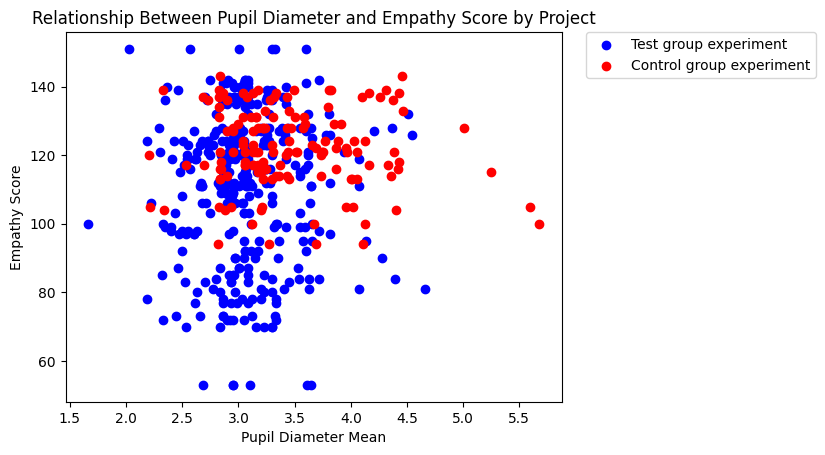

In [ ]:
# Get the unique project names from the 'Project Name' column of the 'result' DataFrame
unique_projects = result['Project Name'].unique()

# Create a new figure and axis for the scatter plot
fig, ax = plt.subplots()

# Iterate through unique projects and corresponding colors
for project, color in zip(unique_projects, ['blue', 'red', 'green']):
    # Filter data for the current project
    project_data = result[result['Project Name'] == project]

    # Create a scatter plot for the current project's data points
    ax.scatter(project_data['Pupil Diameter Mean'], project_data['Total Score extended'], c=color, label=project)

# Set labels and title for the plot
ax.set_xlabel('Pupil Diameter Mean')
ax.set_ylabel('Empathy Score')
ax.set_title('Relationship Between Pupil Diameter and Empathy Score by Project')

# Add a legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Display the plot
plt.show()

**Control Group Experiment**

In [ ]:
# Initialize an empty dictionary to store DataFrames for each project
project_dataframe = {}

# Iterate through unique project names
for project in unique_projects:
    # Filter data for the current project
    project_data = result[result['Project Name'] == project]

    # Store the project data in the dictionary with project name as the key
    project_dataframe[project] = project_data

# Define the names of the projects
project_names = ['Control group experiment', 'Test group experiment']

# Extract DataFrames for the control and test groups from the project_dfs dictionary
control_group = project_dataframe[project_names[0]]
test_group = project_dataframe[project_names[1]]

In [ ]:
pupil_data_test_group = test_group.loc[:, ['Participant Name', 'Pupil Diameter Mean', 'Pupil Diameter Median', 'Pupil Diameter Std', 'Project Name', 'Recording Name', 'Total Score extended']].copy()

In [ ]:
pupil_data_control_group = control_group.loc[:, ['Participant Name', 'Pupil Diameter Mean', 'Pupil Diameter Median', 'Pupil Diameter Std', 'Project Name', 'Recording Name', 'Total Score extended']].copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.svm import SVR

def train(data):
    # Define columns to be dropped from the feature matrix
    drop_columns = ['Total Score extended', 'Project Name', 'Recording Name']

    # Extract features (x) and target (y) from the data
    x = data.drop(columns=drop_columns)
    y = data['Total Score extended']

    # Initialize a DataFrame to store participant-wise prediction results
    final_df = pd.DataFrame(columns=['Participant Name', 'Actual EmScore', 'Predicted EmScore'])

    # Initialize a LabelEncoder to transform participant names to numeric labels
    le = LabelEncoder()
    x['Participant Name'] = le.fit_transform(x['Participant Name'])
    ids = data['Participant Name']

    # Define the number of samples for GroupKFold
    n_samples = 30
    kfold = GroupKFold(n_samples)

    for i, (train, test) in enumerate(kfold.split(x, y, groups=ids)):
        x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]

        #Support Vector Regression
        model = SVR(kernel='sigmoid', C=2.0, epsilon=0.7)

        # Train the model on the training data
        model.fit(x_train, y_train)

        # Predict the target values for the test data
        y_preds = model.predict(x_test)

        for j, (org, pred) in enumerate(zip(y_test, y_preds)):
            # Retrieve the participant's name for the current test instance
            name = data.iloc[itest[j]]['Participant Name']

            # Append the actual and predicted empathy scores to the final DataFrame
            final_df = final_df.append({'Participant Name': name, 'Actual EmScore': org, 'Predicted EmScore': pred}, ignore_index=True)

    # Return the DataFrame containing the participant-wise prediction results
    return final_df

In [ ]:
control_group_results = train(control_group)

In [ ]:
import seaborn as sns

def plot_results(dataframe):
    # Extract actual and predicted empathy scores from the dataframe
    y_test_all = dataframe['Actual EmScore'].tolist()
    y_pred_all = dataframe['Predicted EmScore'].tolist()

    # Create a scatter plot with a regression line
    sns.regplot(x=y_test_all, y=y_pred_all, color='purple', label='Predicted', scatter_kws={'s': 10})

    # Set labels, title, grid, and style for the plot
    plt.xlabel('Actual Empathy Scores')
    plt.ylabel('Predicted Empathy Scores')
    plt.title('Original vs. Predicted Empathy Scores')
    plt.grid(True)
    plt.style.use('ggplot')

    # Plot a line representing perfect prediction
    min_val = min(min(y_test_all), min(y_pred_all))
    max_val = max(max(y_test_all), max(y_pred_all))
    plt.plot([min_val, max_val], [min_val, max_val], color='green', label='Perfect Prediction', linestyle='--')

    # Display the legend and the plot
    plt.legend()
    plt.show()

    return


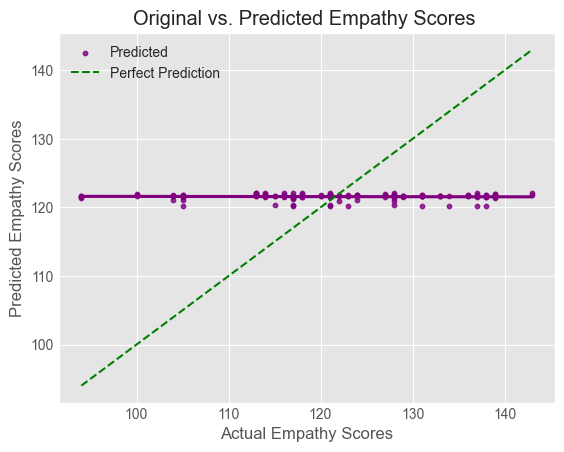

In [ ]:
plot_results(control_group_results)

In [ ]:
test_group_results = train(test_group)
test_group_results.info()

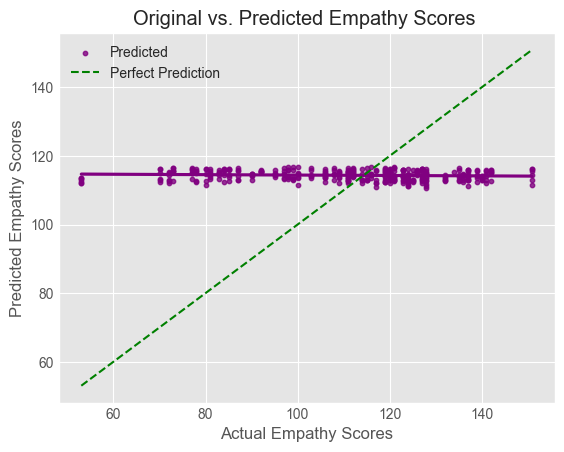

In [ ]:
plot_results(test_group_results)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_empathy_scores(df):
    # Group the DataFrame by participant and calculate mean of actual and predicted empathy scores
    results_test_mean = df.groupby('Participant Name').agg({'Actual EmScore': 'first', 'Predicted EmScore': 'mean'})

    # Set display options for pandas to show all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    print("Grouped DataFrame:")
    # Print the grouped results (you can uncomment this line to display the DataFrame)
    # print(results_test_mean)

    # Melt the DataFrame to make it suitable for visualization
    melted_df = results_test_mean.reset_index().melt(id_vars=['Participant Name'], value_vars=['Actual EmScore', 'Predicted EmScore'], var_name='Score Type', value_name='Score')

    # Display only data for the first 7 participants
    first_7_participants = melted_df['Participant Name'].unique()[:7]
    filtered_df = melted_df[melted_df['Participant Name'].isin(first_7_participants)]

    # Create a line plot to visualize actual and predicted empathy scores
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=filtered_df, x='Participant Name', y='Score', hue='Score Type', style='Score Type', markers=True, dashes=False)

    plt.title('Line Plot of Actual and Predicted Empathy Scores for the First Few Participants', fontsize=15)
    plt.xlabel('Participant Name', fontsize=12)
    plt.ylabel('Empathy Score', fontsize=12)

    plt.grid(True)
    plt.legend(title='Score Type')
    plt.tight_layout()

    # Display the plot
    plt.show()

    return

Grouped DataFrame:


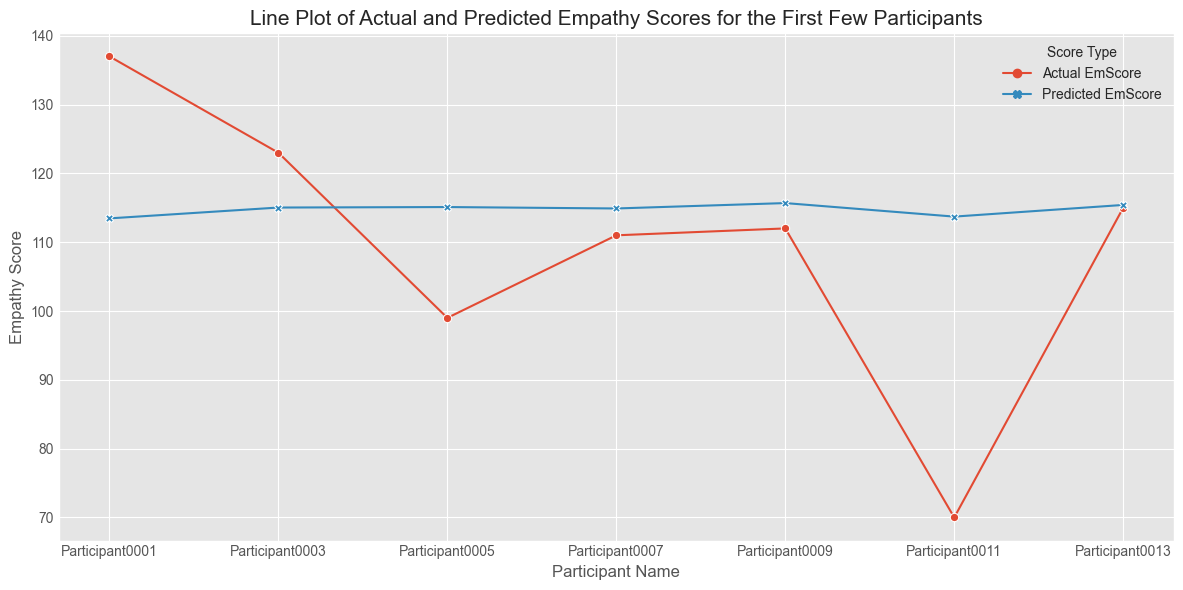

In [ ]:
visualize_empathy_scores(test_group_results)

**Fixation**

In [ ]:
test_group_pupil_results = train(pupil_data_test_group)

Grouped DataFrame:


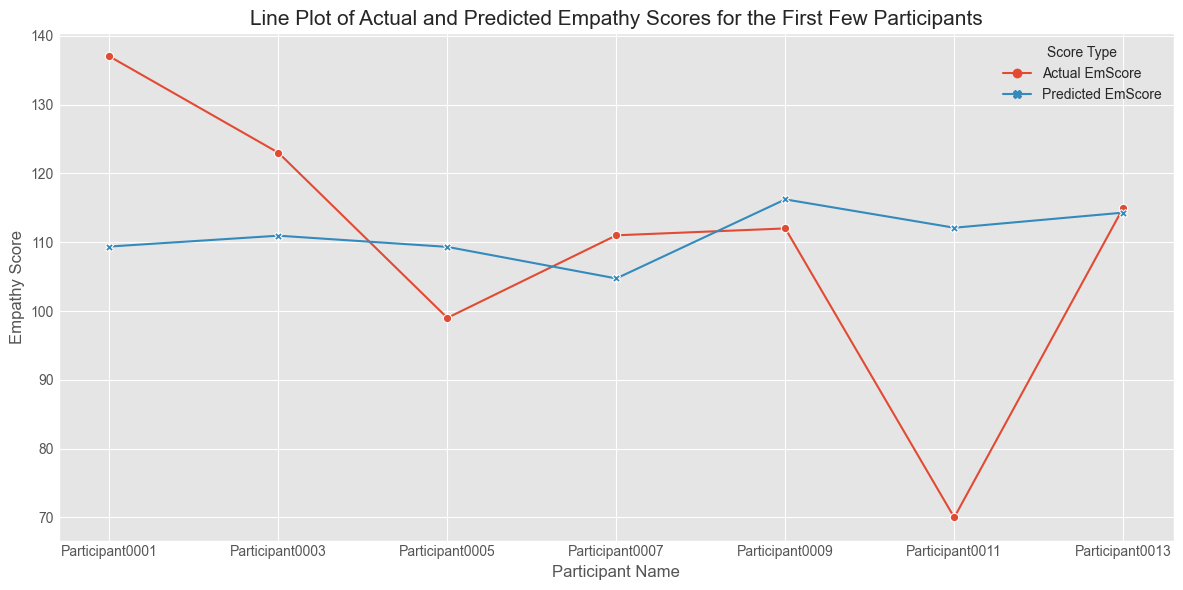

In [ ]:
visualize_empathy_scores(test_group_pupil_results)